In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.interactiveshell import InteractiveShell
import zipfile
import os

%matplotlib inline

In [2]:
os.getcwd()

'C:\\Users\\johnh\\Dropbox\\Coursera\\How to Win a Kaggle Competition\\final_project'

In [3]:
zf = zipfile.ZipFile('competitive-data-science-predict-future-sales.zip') 

In [4]:
# Read items
items = pd.read_csv(zf.open('items.csv'))

# Read sales train
sales_train = pd.read_csv(zf.open('sales_train.csv'))
sales_train['date'] = pd.to_datetime(sales_train['date'], format= '%d.%m.%Y')
sales_train['revenue'] = sales_train['item_price']*sales_train['item_cnt_day']

# Read item categories
item_categories = pd.read_csv(zf.open('item_categories.csv'))

# Read shops
shops = pd.read_csv(zf.open('shops.csv'))

# Read test
test = pd.read_csv(zf.open('test.csv'))


### Graph date_block_num

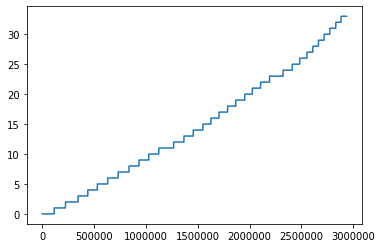

In [5]:
sales_train.date_block_num.plot()

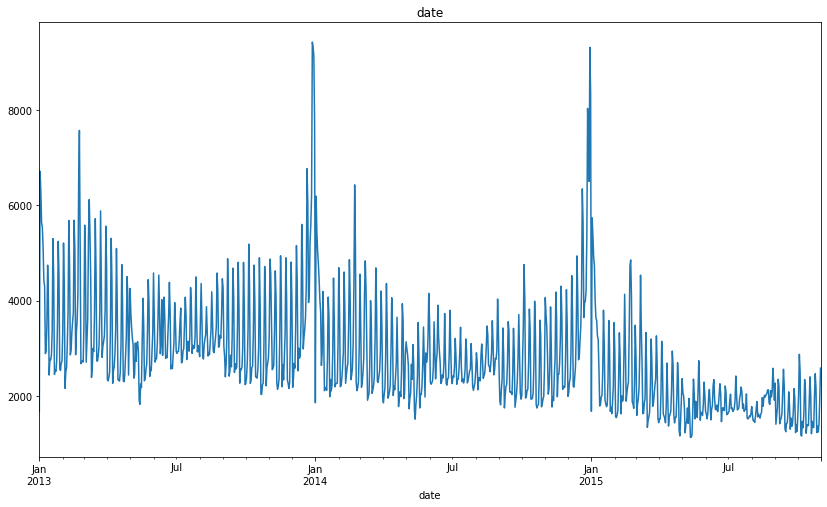

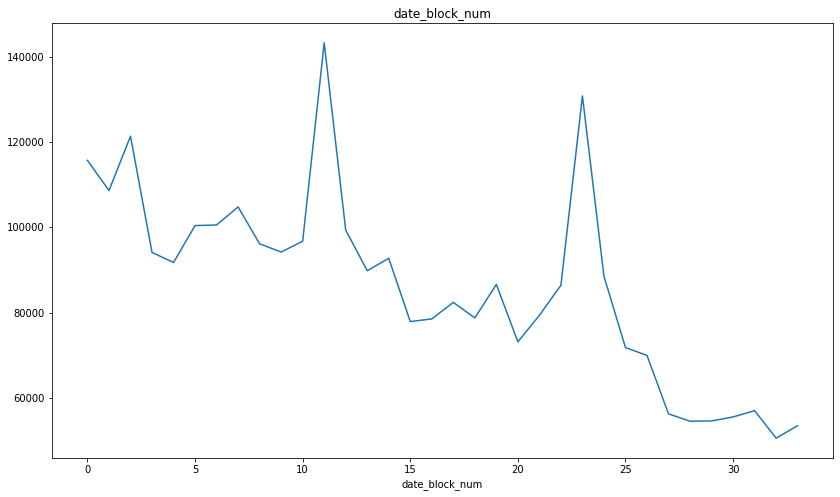

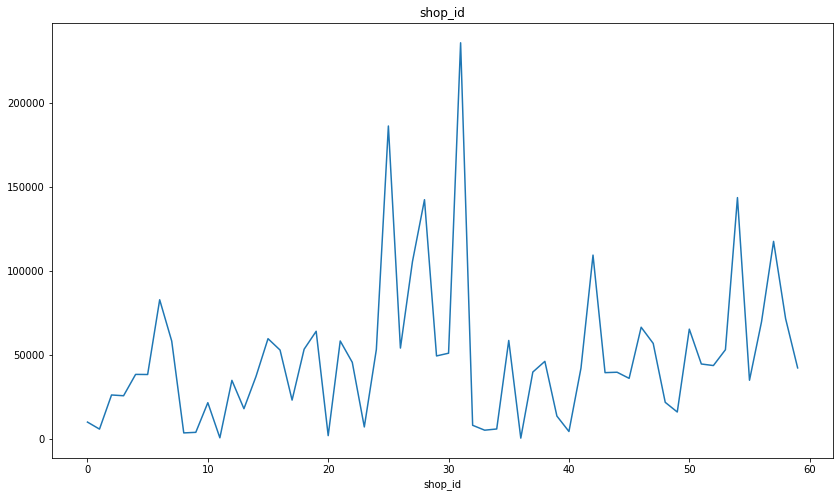

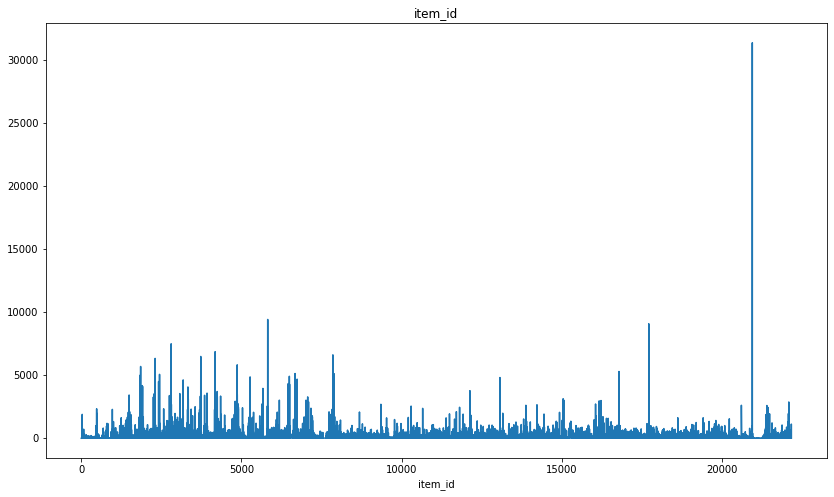

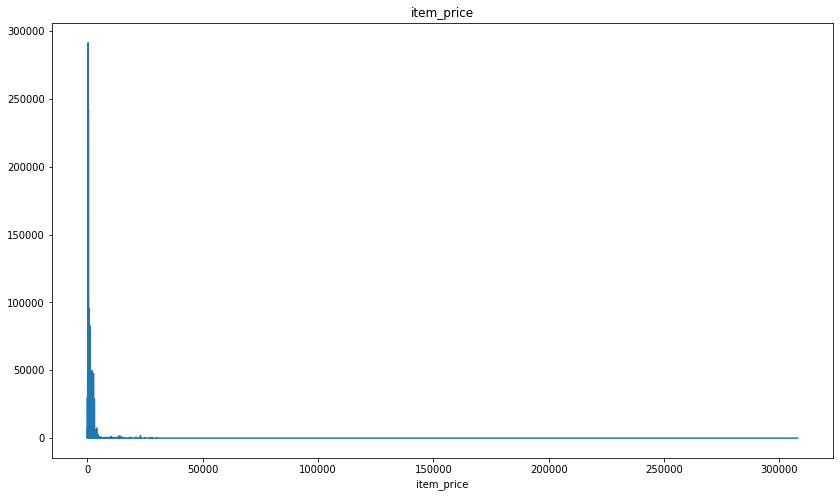

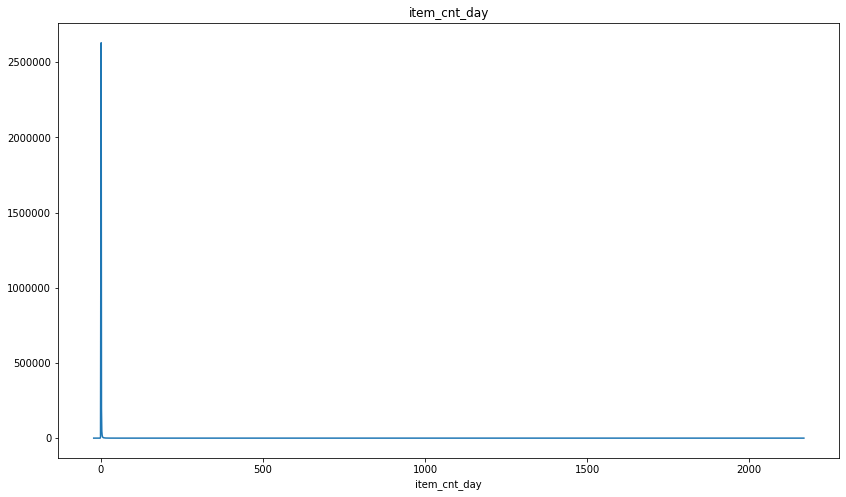

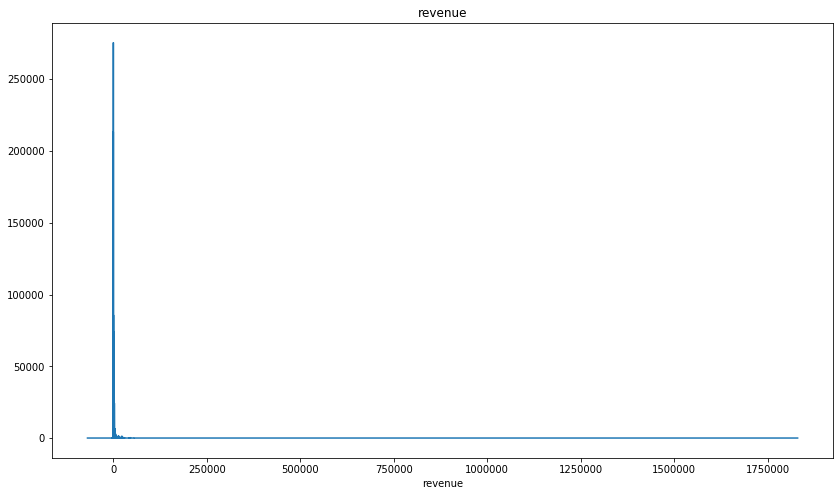

In [6]:
for i in sales_train.columns:
    sales_train.groupby(i).agg(date= (i, 'count')).plot(figsize= (14,8), title= i, legend= False);